In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils
from matplotlib.colors import SymLogNorm
import xesmf as xe
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, display


# Options

### to add
1. option for emissions to be evenly spread, mimic existing spread, or exact input
2. radiation vs. surface level output

In [2]:
region = {'EAS':'China'}
time = '201601*'
compare_2x = True #True allows for comparison to the 2x simulation to see the performance of the GF; False just creates a new GF
global_mean = False #False turns on a spatially explicit version with lat and lon; True turns on a global weighted mean
length_simulation = 25 #days
RRTMG = False
concentration = True

if RRTMG == True:
    diagnostic = 'RRTMG'
if concentration == True:
    diagnostic = 'SpeciesConc'
if RRTMG and concentration == True:
    print('WARNING: Must choose between radiation (RRTMG) and black carbon concentration (concentration) above')

## Import data

In [3]:
ds_delta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/RRTMG_pulse/template/mod_output/GEOSChem.SpeciesConc.{time}', combine = 'by_coords')
ds_emisdelta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/RRTMG_pulse/template/mod_output/GEOSChem.Emissions.{time}', combine = 'by_coords')

#ds_delta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/RRTMG_pulse/{list(region.keys())[0]}/mod_output/GEOSChem.AerosolMass.{time}', combine = 'by_coords')
ds_base = xr.open_mfdataset(f'../GCrundirs/IRF_runs/RRTMG_base/template/mod_output/GEOSChem.SpeciesConc.{time}', combine = 'by_coords', engine = 'netcdf4')
#ds_emisdelta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/RRTMG_pulse/{list(region.keys())[0]}/mod_output/GEOSChem.Emissions.{time}', combine = 'by_coords')
ds_emisbase = xr.open_mfdataset(f'../GCrundirs/IRF_runs/RRTMG_base/template/mod_output/GEOSChem.Emissions.{time}', combine = 'by_coords', engine = 'netcdf4')

In [4]:
def fix_area_ij_latlon(ds):
    ds_area = ds['area']
    ds_area = ds_area.rename({'i':'lat','j':'lon'})
    ds_area['i']= ds['lat']
    ds_area['j'] = ds['lon']
    ds['area'] = ds_area.drop(['j','i'])
    return(ds)

In [5]:
if compare_2x == True:
    #import data
    ds_emis2x = xr.open_mfdataset(f'../GCrundirs/IRF_runs/RRTMG_pulse/template/mod_output/GEOSChem.Emissions.{time}', combine = 'by_coords')
    ds_conc2x = xr.open_mfdataset(f'../GCrundirs/IRF_runs/RRTMG_pulse/template/mod_output/GEOSChem.SpeciesConc.{time}', combine = 'by_coords')
    
    #create one dataset
    ds_emis = xr.concat([ds_emisdelta, ds_emisbase, ds_emis2x], pd.Index(['delta','base', '2x'], name = 'run'))
    ds_conc = xr.concat([ds_delta, ds_base, ds_conc2x], pd.Index(['delta','base', '2x'], name = 'run'))
    
    
else:
    ds_emis = xr.concat([ds_emisdelta, ds_emisbase], pd.Index(['delta','base'], name = 'run'))
    ds_conc = xr.concat([ds_delta, ds_base], pd.Index(['delta','base'], name = 'run'))

In [7]:
ds_conc['BC_total'] = ds_conc['SpeciesConc_BCPI'] + ds_conc['SpeciesConc_BCPO']

In [8]:
ds_emis = fix_area_ij_latlon(ds_emis)
ds_conc= fix_area_ij_latlon(ds_conc)

## Add height to data

In [9]:
height = pd.read_excel('gc_72_estimate.xlsx', index_col = 0)

In [10]:
height_ds = height.diff().dropna().to_xarray().rename({'L':'lev'})
height_ds['lev'] = ds_emis['lev']
height_ds = height_ds.rename({'Altitude (km)':'dz'}) 
height_ds['dz']*=1e3 #convert to meters
height_ds['dz'].attrs = {'units':'m'}

In [11]:
ds_emis = xr.merge([ds_emis, height_ds], join = 'inner')
ds_conc = xr.merge([ds_conc, height_ds], join = 'inner')

In [12]:
sec_day = 86400

In [13]:
utils.combine_BC(ds_emis)

## Define our Conc Difference and Initial Forcing

In [14]:
poll_name = 'BC_total'

In [15]:
if global_mean == True:
    dc_dt = utils.calc_δc_δt_mean(ds_conc, poll_name)
    dc_dt = dc_dt.assign_coords(time = np.arange(.5,len(dc_dt['time'])+.5))

    f0 = (utils.global_w_mean(ds_emis.sel(run = 'delta'), 'EmisBC_Total') - 
          utils.global_w_mean(ds_emis.sel(run = 'base'), 'EmisBC_Total')).isel(time = 0)
else:
    dc_dt = utils.calc_δc_δt(ds_conc, poll_name)
    dc_dt = dc_dt.assign_coords(time = np.arange(.5,len(dc_dt['time'])+.5))
    
    f0 = (utils.global_w_mean(ds_emis.sel(run = 'delta'), 'EmisBC_Total') - 
          utils.global_w_mean(ds_emis.sel(run = 'base'), 'EmisBC_Total')).isel(time = 0)
dc_dt = dc_dt.rename({'time':'s'}) #tp should be s

## Create an F outline for our broadcasting

In [16]:
f = xr.DataArray(
    data = np.zeros(length_simulation),
    dims = ['tp'],
    coords = dict(
        tp = (np.arange(0,length_simulation))),
    )

## Vectorize and Ufunc the Runs to get G

In [17]:
dc_dt_broad, f_broad = xr.broadcast(dc_dt/f0,f)

In [18]:
#dc_dt_broad #create a t variable as a function of tp and s

In [19]:
def my_shift(arr, num, fill_value=0):
    num = int(num)
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    else:
        result[:] = arr
    return result


In [20]:
%%time

if global_mean == True:
    dc_dt_broad = dc_dt_broad.chunk({"tp":1, "s":-1})
    G = xr.apply_ufunc(
    my_shift,
    dc_dt_broad,
    dc_dt_broad.tp.values,
    input_core_dims = [['s'], []],
    output_core_dims = [['s']],
    dask="parallelized",
    vectorize=True,
    kwargs={"fill_value":0.}
    )
    dc_dt_broad = dc_dt_broad.drop('time').rename({'s':'time'})
else:
    dc_dt_broad = dc_dt_broad.chunk({"tp":1, "s":-1})
    G = xr.apply_ufunc(
    my_shift,
    dc_dt_broad,
    dc_dt_broad.tp.values,
    input_core_dims = [['s','lev','lat','lon'], []],
    output_core_dims = [['s','lev','lat','lon']],
    dask="parallelized",
    vectorize=True,
    kwargs={"fill_value":0.},
    output_dtypes = [dc_dt_broad.dtype]
    )
    dc_dt_broad = dc_dt_broad.drop('time').rename({'s':'time'})


CPU times: user 11.7 ms, sys: 1.48 ms, total: 13.2 ms
Wall time: 14.8 ms


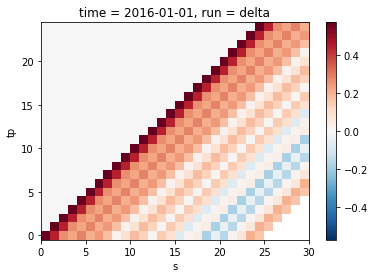

In [21]:
G.weighted((ds_conc['area']*ds_conc['dz']).sel(run = 'delta').isel(time = 0)).mean(dim = ['lat','lon','lev']).plot()
#plt.xlim(0,15)
#plt.ylim(0,15)

# Check the 2x conc vs a 2x emis times GF

In [22]:
dt = 1 #day

## Global Average Comparison

In [23]:
ds_emis = ds_emis.rename({'time':'tp'})

In [24]:
ds_emis = ds_emis.assign_coords(tp = np.arange(0,len(ds_emis['tp'])))

In [25]:
ds_emis_gmean = (ds_emis.sel(run = '2x')-
                 ds_emis.sel(run = 'base')).weighted(
    (ds_emis['area']*ds_emis['dz']).sel(run = 'base').isel(tp = 0)).mean(dim = ['lat','lon','lev'])['EmisBC_Total'].compute()


In [26]:
G_mean = G.weighted((ds_conc['area']*ds_conc['dz']).sel(run = 'delta').isel(time = 0)).mean(dim = ['lat','lon','lev']).compute()

In [27]:
out_mean = G_mean*ds_emis_gmean*dt

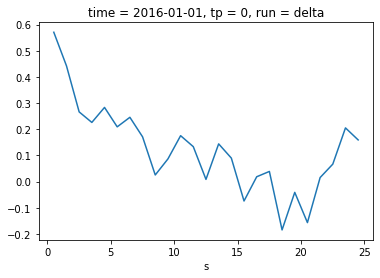

In [28]:
G_mean.sel(tp = 0).plot()

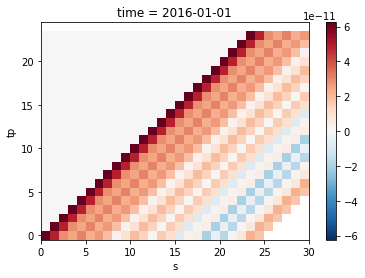

In [29]:
out_mean.plot()

(0.0, 23.0)

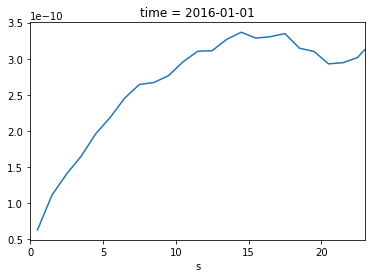

In [34]:
out_mean.sum(dim = 'tp').plot()
plt.xlim(0,23)

(16801.0, 16824.0)

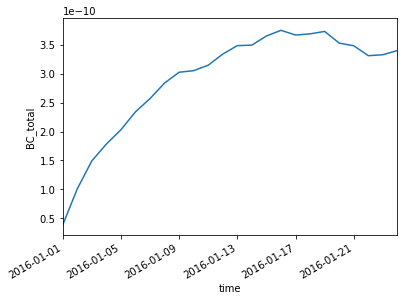

In [36]:
(utils.global_w_mean(ds_conc.sel(run = '2x').fillna(0), poll_name) - utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name)).plot()
plt.xlim('2016-01-01T00:00:00.000000000','2016-01-24T00:00:00.000000000')

## Spatial resolved 

In [37]:
f_2x = (ds_emis.sel(run = '2x')['EmisBC_Total'].weighted((ds_conc['area']*ds_conc['dz']).sel(run = '2x').isel(time = 0)).mean(dim = ['lat','lon','lev']).compute()-
    ds_emis.sel(run = 'base')['EmisBC_Total'].weighted((ds_conc['area']*ds_conc['dz']).sel(run = 'base').isel(time = 0)).mean(dim = ['lat','lon','lev']).compute())

In [38]:
comp_2x = (f_2x*G*dt).sum(dim = 'tp').compute()

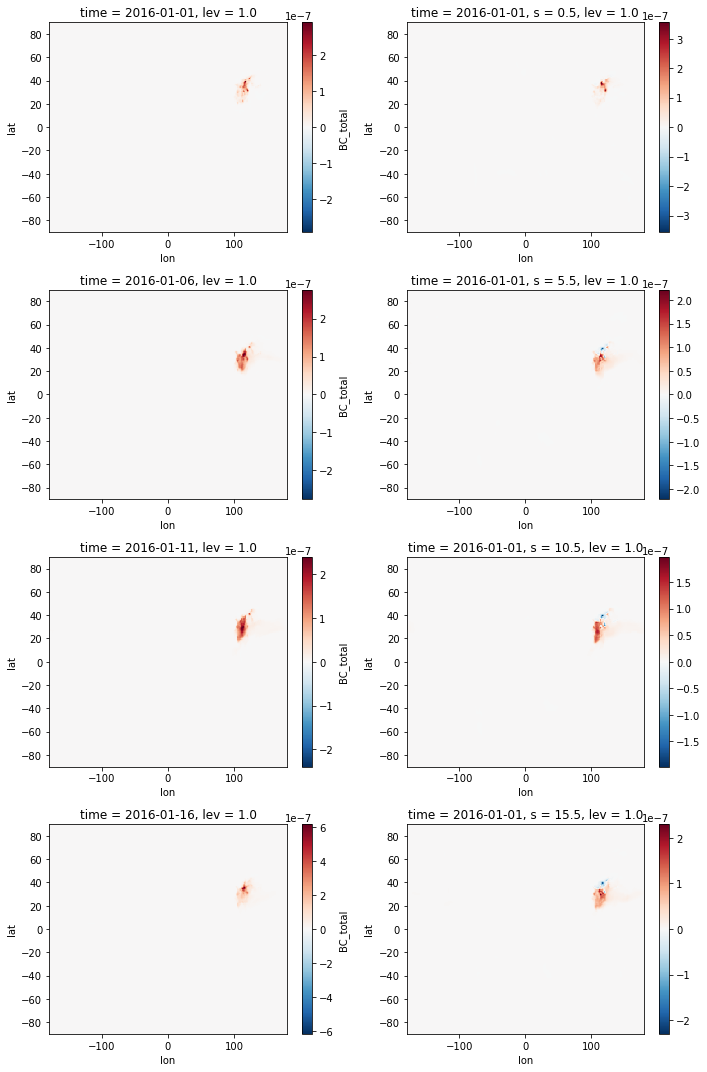

In [39]:
fig, axes = plt.subplots(4,2, figsize = [10,15])
for idx, s in enumerate([0,5,10,15]):
    (ds_conc.sel(run = '2x')-ds_conc.sel(run = 'base')).isel(time =s, lev = 0)[poll_name].plot(ax = axes[idx, 0])
    comp_2x.isel(s = s, lev = 0).plot(ax = axes[idx, 1])
plt.tight_layout()